In [104]:
import pandas as pd
import numpy as np
import os
import itertools
from matplotlib import pyplot as plt 
import networkx as nx
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [92]:
# https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries?select=ds_salaries.csv
salaries = pd.read_csv(r"Data/ds_salaries.csv")
salaries = salaries.drop(columns=["Unnamed: 0", "work_year", "employment_type",
                                  "salary", "salary_currency",])#.sample(n=100, random_state=32)
salaries

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,79833,DE,0,DE,L
1,SE,Machine Learning Scientist,260000,JP,0,JP,S
2,SE,Big Data Engineer,109024,GB,50,GB,M
3,MI,Product Data Analyst,20000,HN,0,HN,S
4,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...
602,SE,Data Engineer,154000,US,100,US,M
603,SE,Data Engineer,126000,US,100,US,M
604,SE,Data Analyst,129000,US,0,US,M
605,SE,Data Analyst,150000,US,100,US,M


### Manipulate Data:

In [93]:
np.random.seed(26)
scaler = StandardScaler()
salaries['salary_in_usd'] = scaler.fit_transform(salaries[['salary_in_usd']]) #maybe log?
#salaries.salary_in_usd.hist(bins = 20)

# Omit countries with low frequency observations 
class_counts = salaries['employee_residence'].value_counts()
salaries = salaries[salaries['employee_residence'].isin(class_counts[class_counts >= 7].index)]

# Omit 100 random us citizens for better group balance 
condition = (salaries['employee_residence'] == "US")
indices_to_remove = salaries[condition].index
indices_to_remove_random = np.random.choice(indices_to_remove, size=282, replace=False)
salaries = salaries.drop(indices_to_remove_random)
salaries


,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,-0.457904,DE,0,DE,L
1,SE,Machine Learning Scientist,2.083282,JP,0,JP,S
2,SE,Big Data Engineer,-0.046177,GB,50,GB,M
10,EN,Data Scientist,-0.860055,FR,0,FR,S
11,MI,Data Scientist,-1.012949,IN,0,IN,L
...,...,...,...,...,...,...,...
600,EN,Data Analyst,-0.638909,CA,0,CA,M
601,EN,Data Analyst,-0.850478,CA,0,CA,M
602,SE,Data Engineer,0.588192,US,100,US,M
605,SE,Data Analyst,0.531774,US,100,US,M


#### Connenction Permutation 

\begin{equation}
C(n, 2) = \frac{{n \cdot (n - 1)}}{2}
\end{equation}
possible Connections

In [94]:
n_permutes = lambda n : int((n * (n-1)) / 2)
print(n_permutes(salaries.shape[0]))

26565


In [95]:
idx_pairs = list(itertools.combinations(salaries.index, 2))

salary_pairs = list(itertools.combinations(salaries.salary_in_usd, 2))
salary_delta = [abs(pair[0] - pair[1]) for pair in salary_pairs]

residence_pairs = list(itertools.combinations(salaries.employee_residence, 2))
fellow_country = [int(pair[0] == pair[1] )for pair in residence_pairs]

experience_pairs = list(itertools.combinations(salaries.experience_level, 2))
same_experience = [int(pair[0] == pair[1] )for pair in experience_pairs]

title_pairs = list(itertools.combinations(salaries.job_title, 2))
same_title = [int(pair[0] == pair[1] )for pair in title_pairs]

df = pd.DataFrame({'idx': idx_pairs, 
                   'wage_delta': salary_delta,
                   'fellow_country': fellow_country, 
                   'same_title': same_title, 
                   'same_experience': same_experience
                   })

Generate Conditional Probabilities based on similarity of observations. 

\begin{equation}
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_{1}x_{1} + \beta_{2}x_{2} + \ldots + \beta_nx_n)}}
\end{equation}

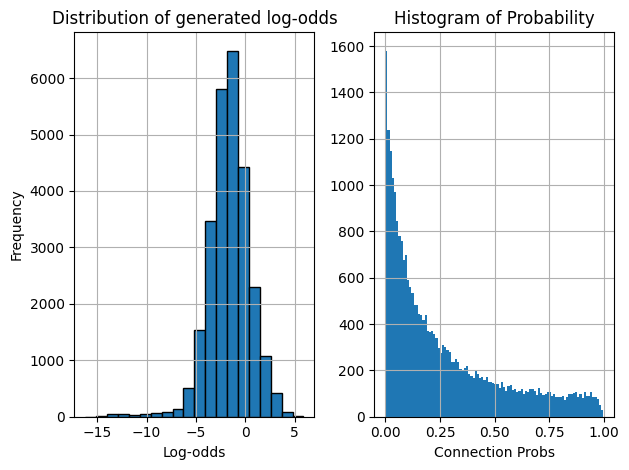

In [96]:
np.random.seed(26)
# A low negative intercept means a low default connection probability (all else = 0)
# Pushing it extremely low, will cause no connections 
beta_0 = -1
# Coefficient for countrymen, 1 -> making it more likely to connect 
beta_cm = np.log(10)  # increase the odds-ratio by _(whats inside the log)
# Coefficient for wagedelta: the larger the gap, the less likely a connection happens 
beta_wd = -1.5 
# Coefficient for same experience: 1 -> making it more likely to connect 
beta_exper = np.log(2) 

beta_ti = np.log(4) 

log_odds = (beta_0 +
            beta_cm * df.fellow_country + 
            beta_wd * df.wage_delta +
            beta_ti * df.same_title +
            beta_exper * df.same_experience +
            np.random.normal(0,1,df.shape[0])) 
# Changes shape of distribution, larger variance -> clearer bounds
# Can break indented structure harshly when too high 

df["Connection_Prob"] = 1 / (1 + np.exp(-log_odds))

plt.subplot(1, 2, 1)
plt.hist(log_odds, bins= 20, edgecolor='black')
plt.title("Distribution of generated log-odds")
plt.xlabel('Log-odds')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
df["Connection_Prob"].hist(bins=100)
plt.title('Histogram of Probability')
plt.xlabel('Connection Probs')

plt.tight_layout()
plt.show()

<Axes: xlabel='wage_delta', ylabel='Connection_Prob'>

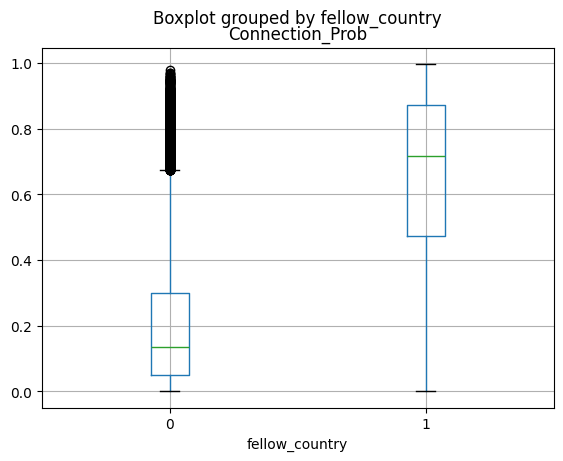

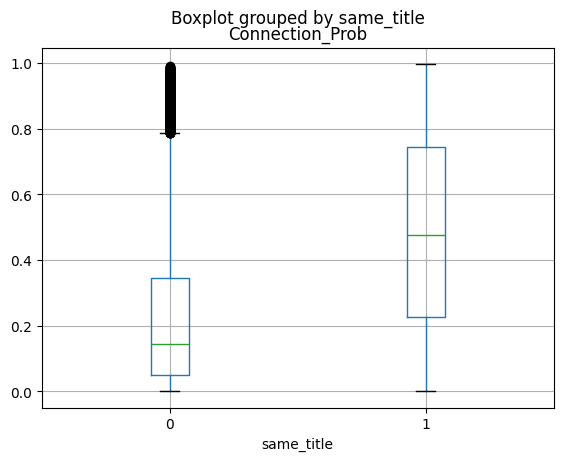

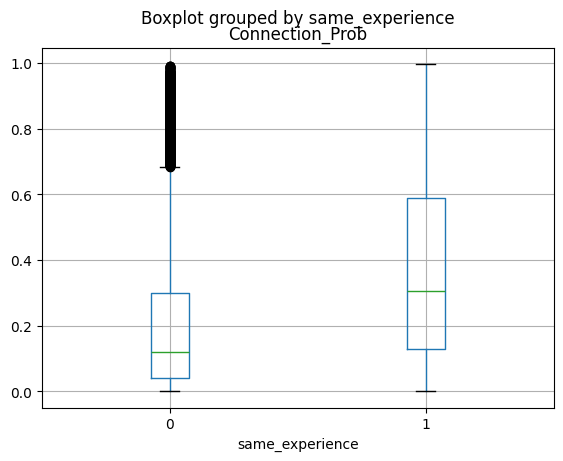

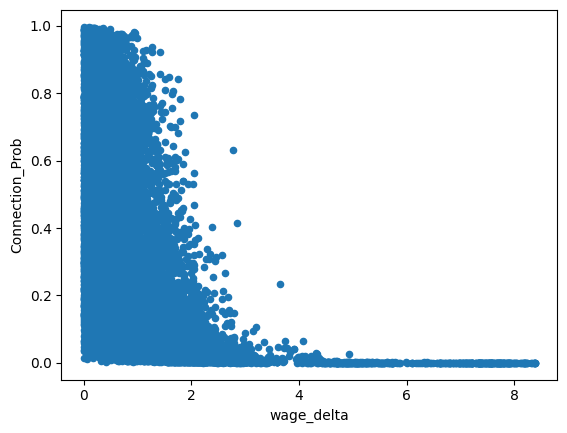

In [97]:
df.boxplot(column = ["Connection_Prob"],
           by = "fellow_country")

df.boxplot(column = ["Connection_Prob"],
           by = "same_title")

df.boxplot(column = ["Connection_Prob"],
           by = "same_experience")

df.plot(kind='scatter',
         x='wage_delta', y="Connection_Prob")


In [128]:
countries = salaries.employee_residence.unique()
color_map = dict(zip(countries,
     np.arange(len(countries))))
country_to_color = lambda x : color_map[x]

G = nx.Graph()
G.add_nodes_from(salaries.index,
                 size = salaries.salary_in_usd)

G.add_edges_from(df[df['Connection_Prob'] > 
                      np.random.uniform(0.1,1.1,df.shape[0])]['idx']
                      )

print(nx.adjacency_matrix(G).toarray().shape)
#print(salaries.shape)

(231, 231)


C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


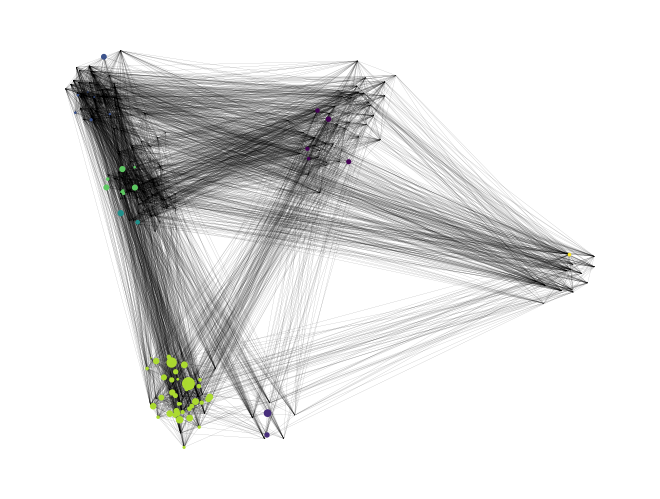

In [129]:
def gen_position(intra_spread, inter_spread): 
    np.random.seed(26)
    mu_y = np.random.normal(0,inter_spread,len(countries)) #linspace(-10,10,len(countries))  
    mu_x = np.random.normal(0,inter_spread,len(countries)) #linspace(-10,10,len(countries))  
    
    cc = (pd.DataFrame(np.array([countries, mu_x, mu_y]).T).
                         set_index(0).apply(tuple, axis=1).to_dict())
    
    position = {index: cc[row['employee_residence']] + np.random.normal(0,intra_spread,2)
     for index, row in salaries.iterrows()}
    
    return position

nx.draw(G, with_labels = False, 
        node_size = salaries.salary_in_usd * 10,
        pos = gen_position(1, 7), 
        node_color = salaries.employee_residence.apply(country_to_color), 
        width = 0.05, alpha = 0.99)


## Learn Connections with GLMS 

In [136]:
from sklearn.preprocessing import FunctionTransformer

df["Target"] = df.Connection_Prob > np.random.uniform(0.5,1,df.shape[0])
# log_transform = lambda x : np.log(x)

X = df.drop(['Target',
             "idx",
             'fellow_country',
             "Connection_Prob"], axis=1)
y = df['Target']

numeric_features = ['wage_delta']
categorical_features = ['same_title',
                        'fellow_country',
                        'same_experience']

numeric_transformer = Pipeline(steps=[
    #('log_transformer', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessing and logistic regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.914549218897045
